# Experiments

Indices based on interpretable ML methods.

In [1]:
import pathlib, sys
sys.path.insert(1, str(pathlib.Path().resolve().parents[0]))

In [2]:
import altair as alt
import numpy as np
import pandas as pd

from hpipy.extensions import GraphNeuralNetworkIndex, NeuralNetworkIndex, RandomForestIndex
from hpipy.period_table import PeriodTable
from hpipy.price_index import HedonicIndex, RepeatTransactionIndex
from hpipy.trans_data import HedonicTransactionData, RepeatTransactionData
from hpipy.utils.metrics import accuracy, revision, series_accuracy, series_volatility, volatility
from hpipy.utils.plotting import (
    plot_index,
    plot_index_accuracy,
    plot_index_volatility,
    plot_series_volatility,
    plot_series_revision,
)

alt.renderers.enable("mimetype");

In [3]:
df_sales = (
    pd.read_csv('../data/kingcountysales.csv', index_col=0, parse_dates=['sale_date'])
    .assign(tot_sf=lambda x: x['sqft'])
    .assign(baths=lambda x: x['bath_full'])
)

In [4]:
sales_hdata = PeriodTable(df_sales).create_period_table(
    date='sale_date',
    periodicity='monthly',
    min_date='2000-01-01',
    max_date=None,
    adj_type='clip',
)

In [5]:
sales_hhdata = HedonicTransactionData(sales_hdata).create_transactions(
    prop_id='pinx',
    trans_id='sale_id',
    price='sale_price',
)

In [6]:
rf_index = RandomForestIndex.create_index(
    sales_hhdata,
    date='sale_date',
    price='sale_price',
    trans_id='sale_id',
    prop_id='pinx',
    estimator='pdp',
    periodicity='monthly',
    dep_var='price',
    ind_var=['tot_sf', 'beds', 'baths'],
    smooth=False,
    sim_ids=None,  # range(0, 10),
    n_estimators=10,
)

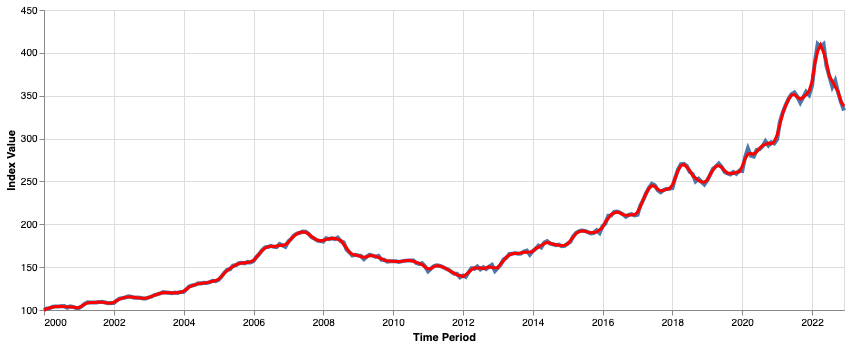

In [7]:
chart1 = plot_index(rf_index.smooth_index(in_place=True), smooth=True)
chart1.display()

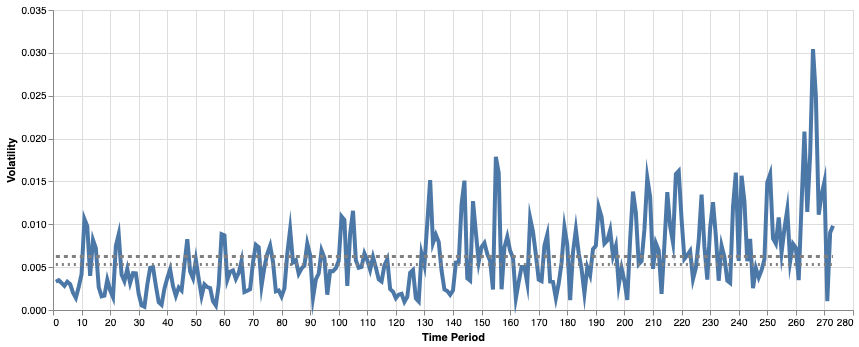

In [8]:
plot_index_volatility(volatility(index=rf_index.smooth, window=3, smooth=False))

In [9]:
rf_series = rf_index.create_series(train_period=24, max_period=30)

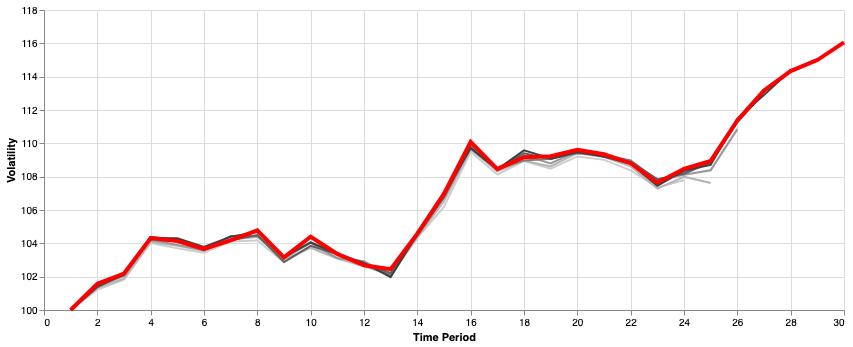

In [10]:
plot_series_volatility(rf_series, smooth=False)

In [11]:
rf_series = rf_series.smooth_series(order=5)

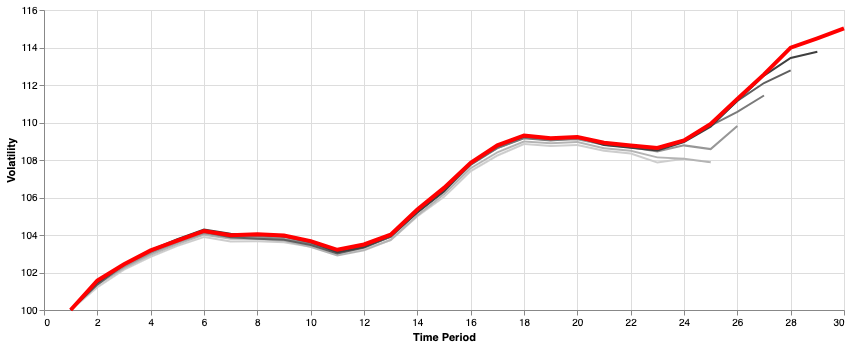

In [12]:
plot_series_volatility(rf_series, smooth=True)

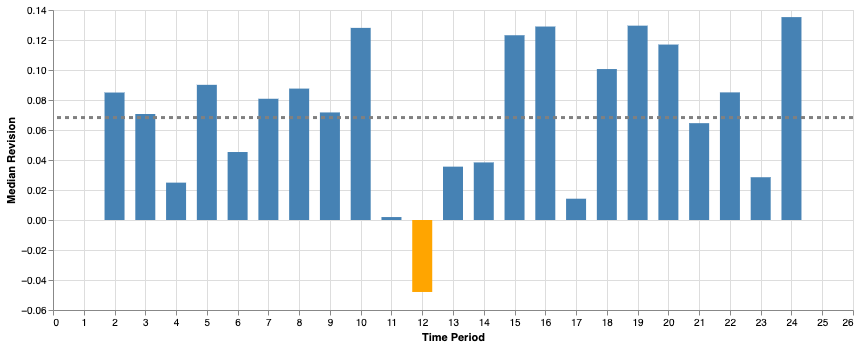

In [13]:
plot_series_revision(revision(rf_series, in_place=True, smooth=False), smooth=False)

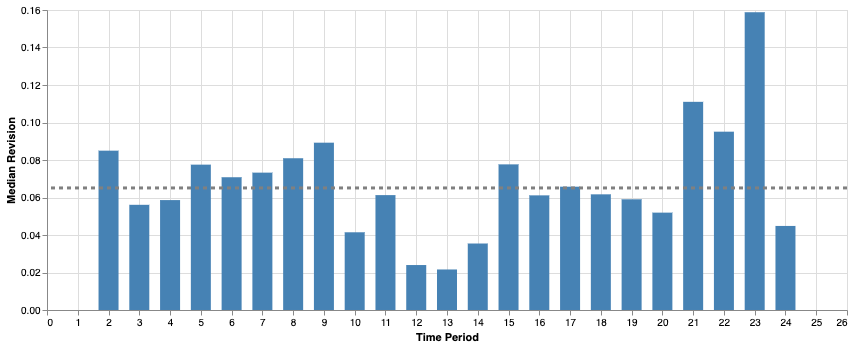

In [14]:
plot_series_revision(revision(rf_series, in_place=True, smooth=True), smooth=True)

In [15]:
nn_index_shap = NeuralNetworkIndex.create_index(
    sales_hhdata,
    date='sale_date',
    price='sale_price',
    trans_id='sale_id',
    prop_id='pinx',
    periodicity='monthly',
    dep_var='price',
    ind_var=['tot_sf', 'beds', 'baths'],
    estimator='attributional',
    preprocess_geo=False,
    feature_dict={
        'numerics': [],
        'log_numerics': ['tot_sf'],
        'categoricals': [],
        'ordinals': ['beds', 'baths'],
        'hpi': []
    },
)

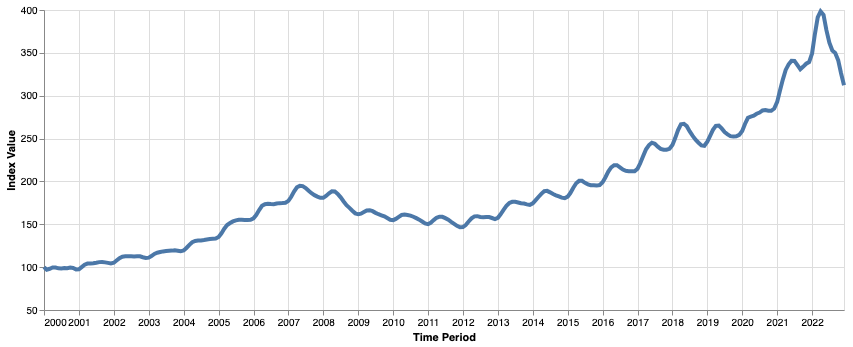

In [16]:
chart2 = plot_index(nn_index_shap)
chart2.display()

In [17]:
nn_index_residual = NeuralNetworkIndex.create_index(
    sales_hhdata,
    date='sale_date',
    price='sale_price',
    trans_id='sale_id',
    prop_id='pinx',
    periodicity='monthly',
    dep_var='price',
    ind_var=['tot_sf', 'beds', 'baths'],
    estimator='residual',
    preprocess_geo=False,
    feature_dict={
        'numerics': [],
        'log_numerics': ['tot_sf'],
        'categoricals': [],
        'ordinals': ['beds', 'baths'],
        'hpi': ['sale_date']
    },
)

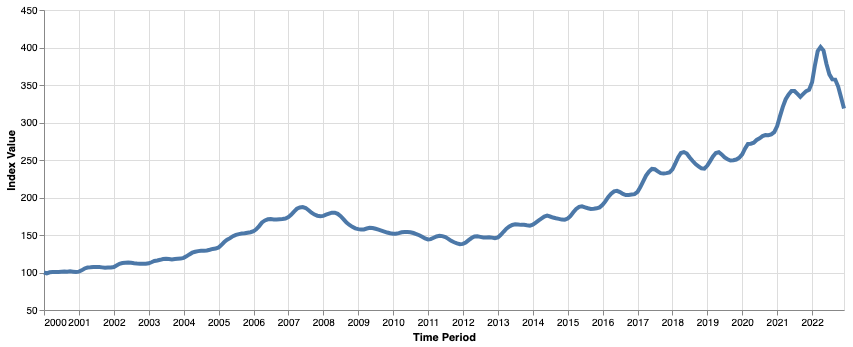

In [18]:
chart3 = plot_index(nn_index_residual)
chart3.display()

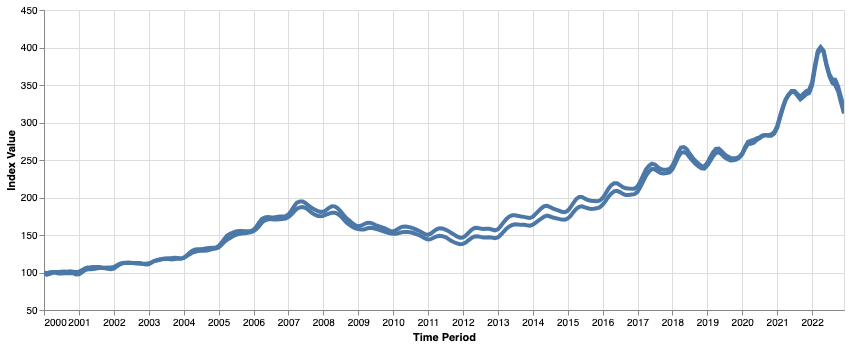

In [19]:
alt.layer(chart2, chart3).interactive()

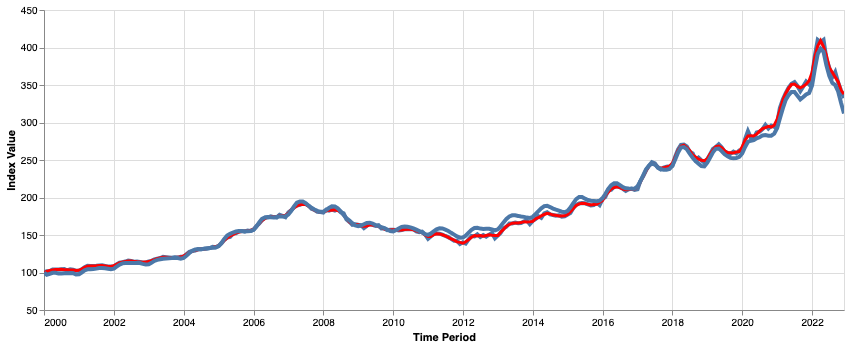

In [20]:
alt.layer(chart1, chart2).interactive()

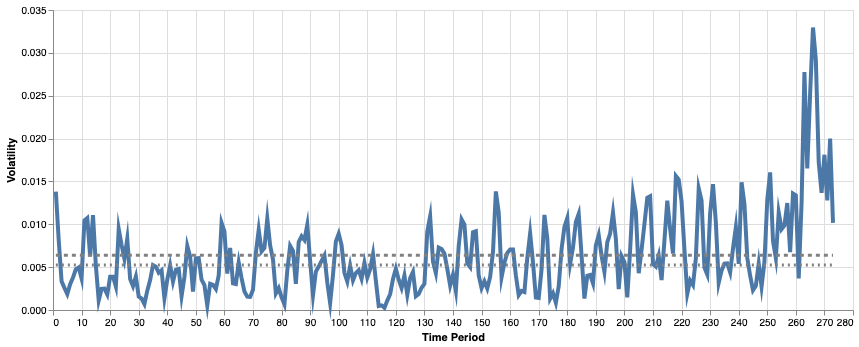

In [21]:
plot_index_volatility(volatility(index=nn_index_residual.value, window=3))

In [22]:
nn_series = nn_index_residual.create_series(train_period=24, max_period=30)

In [23]:
nn_series = nn_series.smooth_series(order=3)

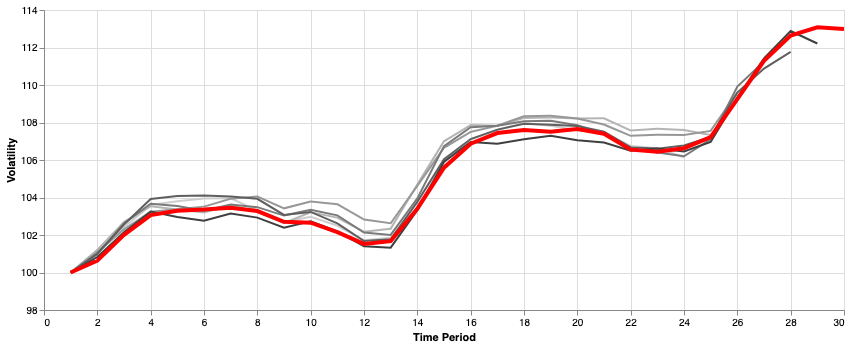

In [24]:
plot_series_volatility(nn_series, smooth=False)

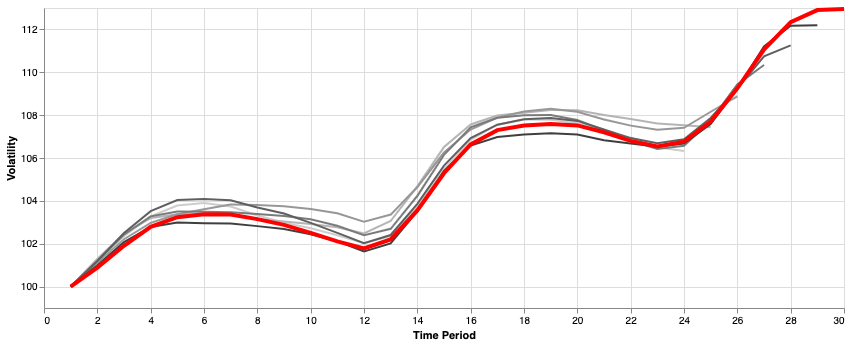

In [25]:
plot_series_volatility(nn_series, smooth=True)

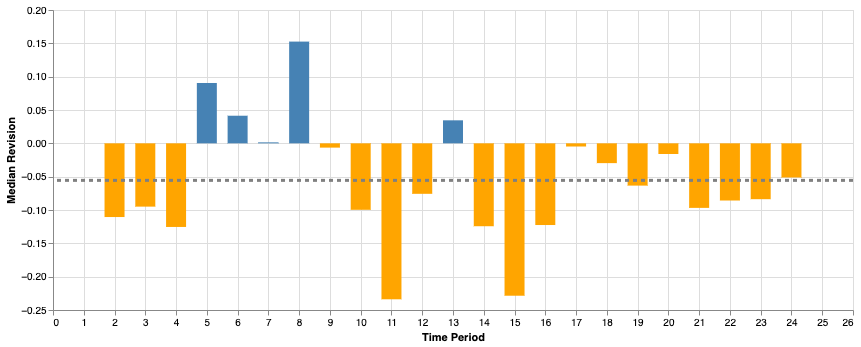

In [26]:
plot_series_revision(revision(nn_series, in_place=True, smooth=False), smooth=False)

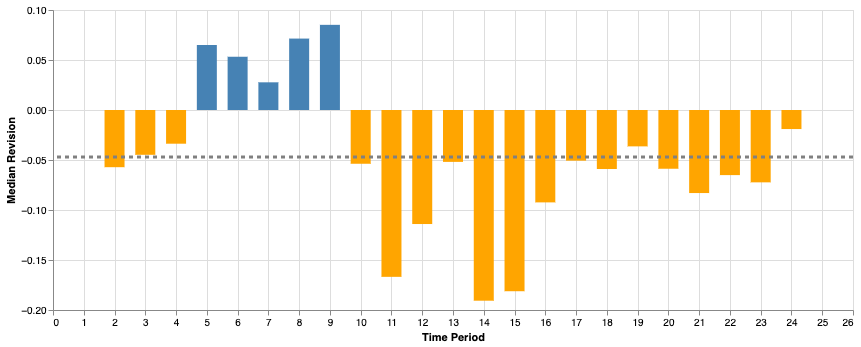

In [27]:
plot_series_revision(revision(nn_series, in_place=True, smooth=True), smooth=True)

In [28]:
gnn_index_residual = GraphNeuralNetworkIndex.create_index(
    sales_hhdata,
    date='sale_date',
    price='sale_price',
    trans_id='sale_id',
    prop_id='pinx',
    periodicity='monthly',
    dep_var='price',
    ind_var=['tot_sf', 'beds', 'baths'],
    estimator='residual',
    preprocess_geo=False,
    feature_dict={
        'numerics': [],
        'log_numerics': ['tot_sf'],
        'categoricals': [],
        'ordinals': ['beds', 'baths'],
        'hpi': ['sale_date']
    },
)

In [29]:
def read_cs(min_date="2000-01-01", seasonally_adjusted=False, return_diff=False):
    name = "SEXRSA" if seasonally_adjusted else "SEXRNSA"
    try:
        df_sexrsa = pd.read_csv(f"../data/{name}.csv")
    except FileNotFoundError:
        # Fetch S&P/Case-Shiller WA-Seattle Home Price Index from FRED.
        print("Fetching S&P/Case-Shiller WA-Seattle Home Price Index from FRED...")
        path = f"https://fred.stlouisfed.org/graph/fredgraph.csv?id={name}"
        df_sexrsa = pd.read_csv(path)

    df_sexrsa = df_sexrsa[df_sexrsa["DATE"] >= min_date].reset_index(drop=True)
    df_xrsa = pd.concat([df_sexrsa], axis=1)
    df_xrsa["month"] = pd.to_datetime(df_xrsa["DATE"], format="%Y-%m-%d")
    df_xrsa = df_xrsa.drop("DATE", axis=1)
    df_xrsa = pd.melt(df_xrsa, id_vars=["month"], value_vars=[name], var_name="index")
    df_xrsa["value"] = df_xrsa["value"] # / 100.
    df_xrsa["Index"] = "Case-Shiller"


    def county_xrsa_index(x):
        x = x.reset_index(drop=True)
        x["value"] = x["value"] * (1. / x["value"][0])
        return x[["Index", "index", "month", "value"]]


    def county_xrsa_index_diff(x):
        x = county_xrsa_index(x)
        x["value"] = x["value"].diff()
        return x[["Index", "index", "month", "value"]]


    df_xrsa = (
        df_xrsa
        .groupby(["index"])
        .apply(lambda x: county_xrsa_index(x))
        .reset_index(drop=True)
    )
    df_xrsa_diff = (
        df_xrsa
        .groupby(["index"])
        .apply(lambda x: county_xrsa_index_diff(x))
        .reset_index(drop=True)
    )

    df_xrsa["value"] *= 100

    return (df_xrsa, df_xrsa_diff) if return_diff else df_xrsa


def get_index(index):
    df_index = (
        pd.DataFrame(index, columns=["date", "value"])
        .assign(month=lambda x: pd.to_datetime(x["date"], format="%Y-%b"))
        .drop(columns=["date"])
        .assign(value_low=0)
        .assign(value_high=0)
    )
    return df_index


def plot_indices(df, region=None, height=None, width=None, max_plot_date=None):
    source = df.copy()

    source["month"] = pd.to_datetime(source["month"], format="%Y-%m-%d")
    source["month"] = source["month"].dt.to_period("M").dt.to_timestamp("M")

    if max_plot_date is not None:
        source = source[source["month"] < pd.to_datetime(max_plot_date)]

    if region is not None:
        source = source[source["index"] != "Case-Shiller"]
        source["index"] = source[region]
        index_title = region
        index_sort = list(source[region].value_counts().index)
    else:
        index_title = "Method"
        index_sort = sorted(source["index"].unique())

    lines = alt.Chart(source).mark_line().encode(
        x=alt.X("month:T", axis=alt.Axis(format="%Y", labelAngle=0, title="Date")),
        y=alt.Y("value:Q", title="Index"),
        color=alt.Color("index:N", sort=index_sort),
        tooltip=[
            alt.Tooltip("month:T", format="%b %Y", title="Date"),
            alt.Tooltip("index:N", title=index_title),
            alt.Tooltip("value_low:Q", format=".3f", title="Value (Low)"),
            alt.Tooltip("value:Q", format=".3f", title="Value"),
            alt.Tooltip("value_high:Q", format=".3f", title="Value (High)"),
        ],
    )
    if height is not None:
        lines = lines.properties(height=height)
    if width is not None:
        lines = lines.properties(width=width)

    errorbars = lines.mark_errorband(opacity=0.33).encode(
        x=alt.X("month:T", axis=alt.Axis(format="%Y", labelAngle=0, title="Date")),
        y=alt.Y("value_low:Q", title=""),
        y2=alt.Y2("value_high:Q", title=""),
        color=alt.Color("index:N", title=index_title, sort=index_sort),
    )

    if max_plot_date is not None:
        df_cutoff = pd.DataFrame({
            "start": [pd.to_datetime(max_plot_date)],
            "stop": [pd.to_datetime(max_plot_date)],
        })

        cutoff = alt.Chart(df_cutoff).mark_rect(
            opacity=0.2,
            color="red",
        ).encode(
            x=alt.X("start:T"),
            x2=alt.X2("stop:T"),
            y=alt.value(0),
            y2=alt.value(300),
        )


    if region is None:
        chart1 = lines + errorbars
    else:
        chart1 = lines

    if max_plot_date is not None:
        chart1 = chart1 + cutoff

    chart1 = chart1.interactive()

    # Month-over-month difference.
    source_diff = source.copy()
    source_diff = source_diff.fillna(0)
    for index in source_diff["index"].unique():
        cols = ["value_low", "value", "value_high"]
        for col in cols:
            idx = source["index"] == index
            source_diff.loc[idx, col] = source_diff.loc[idx, col].diff()

    lines_diff = lines.encode(
        y=alt.Y("value:Q", title="Index Diff")
    ).properties(
        data=source_diff,
    )
    errorbars_diff = lines_diff.mark_errorband(opacity=0.2).encode(
        x=alt.X("month:T", axis=alt.Axis(format="%Y", labelAngle=0, title="Date")),
        y=alt.Y("value_low:Q", title=""),
        y2=alt.Y2("value_high:Q", title=""),
        color=alt.Color("index:N", title=index_title, sort=index_sort),
    )

    if region is None:
        chart2 = lines_diff + errorbars_diff
    else:
        chart2 = lines_diff

    if max_plot_date is not None:
        chart2 = chart2 + cutoff

    chart2 = chart2.interactive()

    return chart1 & chart2
    
    
def plot_seattle_indices(indices, max_plot_date=None):
    if max_plot_date is None:
        max_plot_date = df["sale_date"].max().strftime("%Y-%m-%d")

    df_cs = (
        read_cs(seasonally_adjusted=False)
        .drop(columns="Index")
        .assign(value_low=lambda x: 0)
        .assign(value_high=lambda x: 0)
        .assign(month=lambda x: x["month"].dt.strftime("%Y-%m-%d"))
        .assign(index=lambda x: "Case-Shiller")
    )

    kwargs = {
        "region": None,
        "seasonally_adjusted": False,
        "max_year": pd.to_datetime(max_plot_date).year,
    }

    index_list = [df_cs]
    for index_name, index_obj in indices.items():
        df_index = get_index(index_obj)
        df_index["index"] = index_name
        index_list.append(df_index)

    df_indices = (
        pd.concat(index_list)
        .assign(value_low=lambda x: x["value"] - x["value_low"])
        .assign(value_high=lambda x: x["value"] + x["value_high"])
    )

    chart = plot_indices(
        df_indices,
        height=250,
        width=800,
        max_plot_date=max_plot_date,
    )
    chart = chart.properties(
        title=alt.TitleParams("Seattle Area HPIs", anchor="middle"),
    )

    return chart

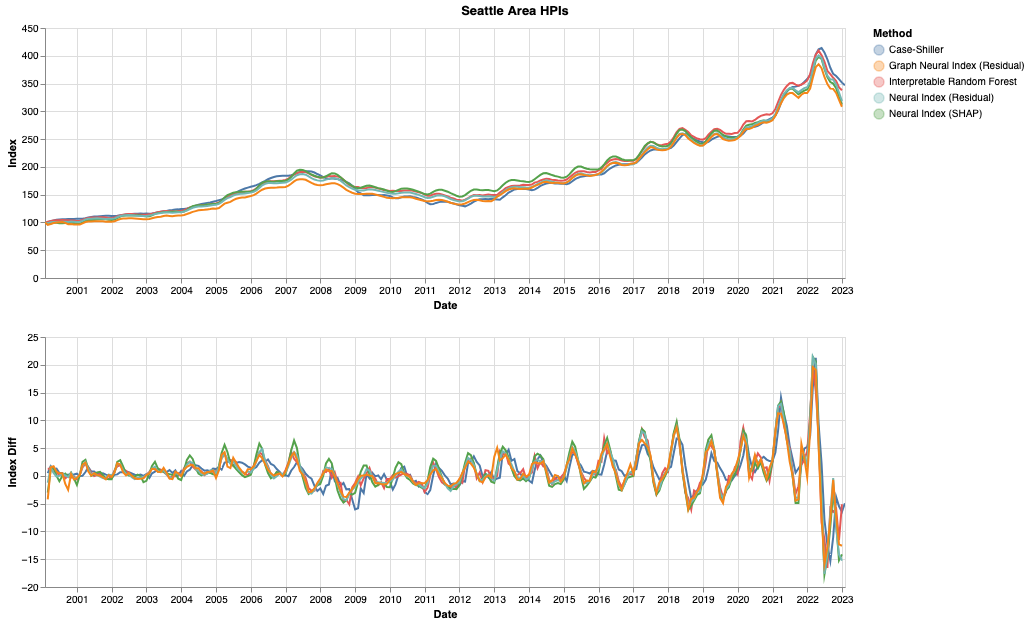

In [30]:
indices = {
    "Interpretable Random Forest": pd.concat(
        [rf_index.data.period_table["name"], rf_index.smooth], axis=1
    ).values,
    "Neural Index (SHAP)": pd.concat(
        [nn_index_shap.data.period_table["name"], nn_index_shap.value], axis=1
    ).values,
    "Neural Index (Residual)": pd.concat(
        [nn_index_residual.data.period_table["name"], nn_index_residual.value], axis=1
    ).values,
    "Graph Neural Index (Residual)": pd.concat(
        [gnn_index_residual.data.period_table["name"], gnn_index_residual.value], axis=1
    ).values,
}
plot_seattle_indices(indices, max_plot_date="2023-02-01").display()